In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image
import pandas as pd
import os

In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

#Load ImageNet pre-trained ViT
model_name = 'google/vit-base-patch16-224-in21k' #Model version

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = 5,
    problem_type="multi_label_classification"
) 

# Feature extractor for preprocessing images
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

# DATASET.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("minhnhat232/dataset-covid-bacterial-viral-normal-emphysema")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/dataset-covid-bacterial-viral-normal-emphysema
['Dataset_5_Class_Original', 'Dataset_5_Class_Crop']


In [9]:
#Read dataset.
original_path = "/kaggle/input/dataset-covid-bacterial-viral-normal-emphysema/Dataset_5_Class_Original/Dataset_5_Class_Original"

# List files inside the original dataset
files = os.listdir(original_path)
print("Files in dataset:", files[:10])  # Show first 10 files


Files in dataset: ['validation', 'test', 'train']


In [10]:
dataset_path = "/kaggle/input/dataset-covid-bacterial-viral-normal-emphysema/Dataset_5_Class_Original/Dataset_5_Class_Original"

# Check subdirectories inside train, test, and validation
for folder in ["train", "test", "validation"]:
    folder_path = os.path.join(dataset_path, folder)
    print(f"Classes in {folder}:", os.listdir(folder_path))

Classes in train: ['Normal', 'Covid-19', 'Emphysema', 'Pneumonia-Viral', 'Pneumonia-Bacterial']
Classes in test: ['Normal', 'Covid-19', 'Emphysema', 'Pneumonia-Viral', 'Pneumonia-Bacterial']
Classes in validation: ['Normal', 'Covid-19', 'Emphysema', 'Pneumonia-Viral', 'Pneumonia-Bacterial']


(1024, 1024, 3)
(1185, 1161, 3)
(1024, 1024, 3)
(1216, 1768, 3)
(688, 952, 3)


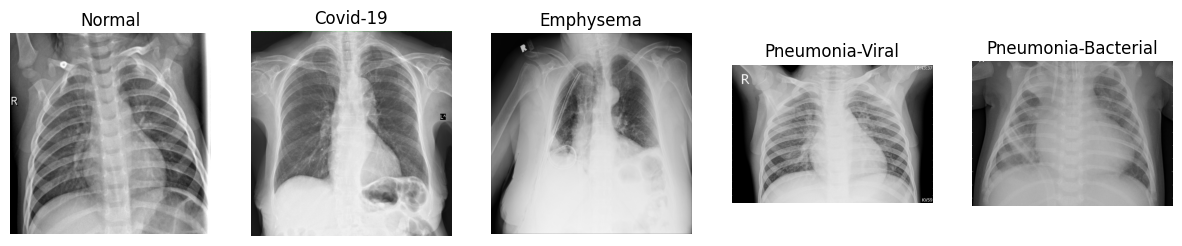

In [14]:
import matplotlib.pyplot as plt
import cv2

train_path = os.path.join(dataset_path, "train")

# Choose a few sample images
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, class_name in enumerate(os.listdir(train_path)[:num_images]):  # Loop through first few classes
    class_dir = os.path.join(train_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    if image_files:
        img_path = os.path.join(class_dir, image_files[0])  # Take the first image
        img = cv2.imread(img_path)
        print(img.shape)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Display the image
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")

plt.show()

In [15]:
processed_dataset_path = "/kaggle/working/Dataset_Processed"

# Process each split
for split in ["train", "test", "validation"]:
    split_path = os.path.join(dataset_path, split)
    new_split_path = os.path.join(processed_dataset_path, split)
    os.makedirs(new_split_path, exist_ok=True)

    # Process images
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        new_class_dir = os.path.join(new_split_path, class_name)
        os.makedirs(new_class_dir, exist_ok=True)

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            new_img_path = os.path.join(new_class_dir, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            cv2.imwrite(new_img_path, img)  # Save

print("Grayscale conversion complete!")

Grayscale conversion complete!


# TRAIN.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()  # for multi-label classification

epochs = 1  # adjust as needed

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        inputs = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=inputs)
        logits = outputs.logits

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")
